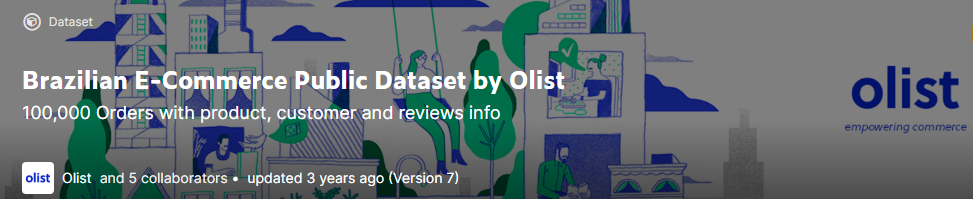

# "Previsão de Cancelamento de Pedido"

**O Problema:**

Algumas compras são canceladas pelos clientes oque diminui o faturamento da empresa e muitas vezes custeia à estrutura até o momento do estorno

**Como resolver isso com data science?**

Criar um algorítimo que tenha capacidade analítica para elencar quais clientes tem "hipótese de cancelar", irei fazer isso usando atributos das ordens como "Target". Caso o algorítimo seja preciso em dizer qual ordem foi cancelada com atributos que existem antes do cancelamento, ele pode gerar uma lista de "possíveis canceladores".



*Obs: seguirei uma abordagem CRISP, então vou resolver o mesmo problema do início até o deploy em fases passando várias vezes de maneira cíclica em cada fase, até conseguir uma precisão que julgue satisfatória ou até "quase impossível" de aumentar.*

## Importar bibliotecas

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark")
import plotly.express as px
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

ModuleNotFoundError: No module named 'seaborn'

## Carregamento e tipagem dos Dados

In [ ]:
dfdata = pd.read_csv('olist.csv')

In [ ]:
dfdata

In [ ]:
dfdata.info()

# corretos: 0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 29
# incorretos: (4, 5, 6, 7, 8, 9) são datas mas estão como "object". E  26, 27 são ceps estão como numeros inteiros

Vamos converter as datas para a tipagem correta:

In [ ]:
dfdata['DATA_LIMITE_ENTREGA_PARCEIRO_LOGISTICO'] = pd.to_datetime(dfdata['DATA_LIMITE_ENTREGA_PARCEIRO_LOGISTICO'], format = '%Y-%m-%d %H:%M:%S' , errors = 'coerce')
dfdata['DATA_PAGAMENTO'] = pd.to_datetime(dfdata['DATA_PAGAMENTO'], format = '%Y-%m-%d %H:%M:%S' , errors = 'coerce')
dfdata['DATA_APROVACAO_PAGAMENTO'] = pd.to_datetime(dfdata['DATA_APROVACAO_PAGAMENTO'], format = '%Y-%m-%d %H:%M:%S' , errors = 'coerce')
dfdata['DATA_POSTAGEM'] = pd.to_datetime(dfdata['DATA_POSTAGEM'], format = '%Y-%m-%d %H:%M:%S' , errors = 'coerce')
dfdata['DATA_ESTIMADA_ENTREGA'] = pd.to_datetime(dfdata['DATA_ESTIMADA_ENTREGA'], format = '%Y-%m-%d %H:%M:%S' , errors = 'coerce')
dfdata['DATA_ENTREGUE'] = pd.to_datetime(dfdata['DATA_ENTREGUE'], format = '%Y-%m-%d %H:%M:%S' , errors = 'coerce')

Vamos converter os ceps para tipagem correta:

In [ ]:
dfdata['PREFIXO_CEP_CLIENTE'] = dfdata['PREFIXO_CEP_CLIENTE'].apply(str)

In [ ]:
dfdata['PREFIXO_CEP_VENDEDOR'] = dfdata['PREFIXO_CEP_VENDEDOR'].apply(str)

In [ ]:
dfdata.info() # pronto

## Limpeza de Nulos

Aqui verificamos locais com dados nulos e preenchemos adequadamente

In [ ]:
dfdata.isnull().sum()

- 15 nulos na data aprovacao - provavelmente foi cancelado ou não aprovado, ou podem ainda estar pra entregar.

- 1245 nulos da data de postagem - provavelmente foram cancelados antes, ou podem ainda estar pra entregar.

- 2567 nulos na data de entrega - podem ter sido cancelados, ou podem ainda estar pra entregar.

- 1698 nulos no nome da categororia e na quantia de fotos.

- 20 nulos em dados sobre peso, comprimento, largura, e altura. provavelmente compras onde o anunciante não colocou nada disso nos dados do produto.

### Nulos: DATA_APROVACAO_PAGAMENTO

Vamos observar o status da ordem dos nulos na coluna 'DATA_APROVACAO_PAGAMENTO'

In [ ]:
dfdata.loc[(dfdata['DATA_APROVACAO_PAGAMENTO'].isnull()) & (dfdata['TARGET_STATUS_DA_ORDEM'] == "delivered")]

# ou seja em todos os que a data de aprovação está nula, os clientes receberam os pedidos mesmo assim
# substituindo os nulos pelo oq?

Em todos os pedidos com valores nulos na data de parovação o status da ordem é o mesmo "delivered". Oque é curioso, tendo em vista que da o entendimento de que pedidos foram entregues sem aprovação do pagamento

In [ ]:
dfdata['METODO_PAGAMENTO'].loc[dfdata['DATA_APROVACAO_PAGAMENTO'].isnull()]

Em todos os pedidos nulos na coluna data de aprovação o método de pagamento foi boleto, provavelmente o pedido foi entregue antes da devida compensação do boleto, como são apenas 15 registros nessa situação, vou tira-lôs do dataset

In [ ]:
dfdata = dfdata[dfdata['DATA_APROVACAO_PAGAMENTO'].notna()]

In [ ]:
dfdata

### Nulos: DATA_POSTAGEM

In [ ]:
dfdata.loc[dfdata['DATA_POSTAGEM'].isnull()]

# nesses a data de entrega parece também está como NaN

In [ ]:
dfdata['TARGET_STATUS_DA_ORDEM'].loc[dfdata['DATA_POSTAGEM'].isnull()]

É perceptivel que nessas datas temos muitas ordens canceladas e que justamente por isso não possuem data de postagem, a questão é, necessariamente todas ordens canceladas não chegam a ser postadas?

In [ ]:
dfdata.loc[dfdata['TARGET_STATUS_DA_ORDEM'] == 'canceled']

In [ ]:
dfdata.loc[(dfdata['TARGET_STATUS_DA_ORDEM'] == 'canceled') & (dfdata['DATA_POSTAGEM'].isnull())]

Não! Temos 566 pedidos cancelados e o pedido não foi postado em 487 desses casos, portanto temos 79 pedidos que foram postados mas cancelados mesmo assim

Não posso utilizar essa variável como atributo previsor em algoritimos de classificação, tendo em vista o fato dessa categoria estar nula por vezes é justamente consequência do cancelamento, portanto isso não trária capacidade preditiva para essa variável

As unicas variaveis de datas sem valores nulos são a de pagamento (pois isso é condição pra "compra" existir no servidor) e a data de precisão de entrega, que provavelemte é fornecida para o comprador quando vai comprar o produto, portanto essas duas variaveis existem anteriormente ao cancelamento e podem ser ussadas como atributos previsores

### Nulos: NOME_CATEGORIA_PRODUTO

In [ ]:
dfdata['NOME_CATEGORIA_PRODUTO'].loc[dfdata['NOME_CATEGORIA_PRODUTO'].isnull()]

In [ ]:
dfdata['NOME_CATEGORIA_PRODUTO']

Existem produtos sem categoria, provavelmente o produto era diferente demais para ser dcategorizado ou o anunciante não colocou nada, portanto vamos criar uma categoria de produtos chamada "sem_categoria" para substituir esses nulos

In [ ]:
dfdata['NOME_CATEGORIA_PRODUTO'].fillna('sem_categoria', inplace=True)

In [ ]:
dfdata['NOME_CATEGORIA_PRODUTO'].loc[dfdata['NOME_CATEGORIA_PRODUTO'] == 'sem_categoria'] # feito

### Nulos: QUANTIA_FOTOS_ANUNCIO

In [ ]:
dfdata['QUANTIA_FOTOS_ANUNCIO'].fillna(0, inplace=True)

In [ ]:
dfdata['QUANTIA_FOTOS_ANUNCIO'].loc[dfdata['QUANTIA_FOTOS_ANUNCIO'] == 0] # feito

### Nulos: PESO_EM_GRAMAS / COMPRIMENTO_EM_CENTIMETROS /  LARGURA_PRODUTO_EM_CENTIMETROS /  ALTURA_PRODUTO_EM_CENTIMETROS

In [ ]:
dfdata.isnull().sum()

In [ ]:
dfdata['LARGURA_PRODUTO_EM_CENTIMETROS'].loc[dfdata['PESO_EM_GRAMAS'].isnull()] 

# os produtos onde um é nulo são todos iguais

**Para substituir os valores de tamanho irei calcular as médias de tamanho para cada categoria e irei substituir os nulos pela média da categoria que o produto pertence**

In [ ]:
dfdata['NOME_CATEGORIA_PRODUTO'].loc[dfdata['PESO_EM_GRAMAS'].isnull()] 

O problema é que na maioria dos casos os produtos sem atributos de tamanho não tem categoria alguma, portanto irei calcular as médias os produtos sem categoria

In [ ]:
dfdata.loc[dfdata['NOME_CATEGORIA_PRODUTO'] =='sem_categoria'].mean()

In [ ]:
dfdata['COMPRIMENTO_EM_CENTIMETROS'].fillna(26.59, inplace=True)

In [ ]:
dfdata['PESO_EM_GRAMAS'].fillna(1881.23, inplace=True)

In [ ]:
dfdata['LARGURA_PRODUTO_EM_CENTIMETROS'].fillna(20.17, inplace=True)

In [ ]:
dfdata['ALTURA_PRODUTO_EM_CENTIMETROS'].fillna(14.69, inplace=True)

In [ ]:
dfdata.isnull().sum()

# Mapa de hipóteses

In [ ]:
df.columns

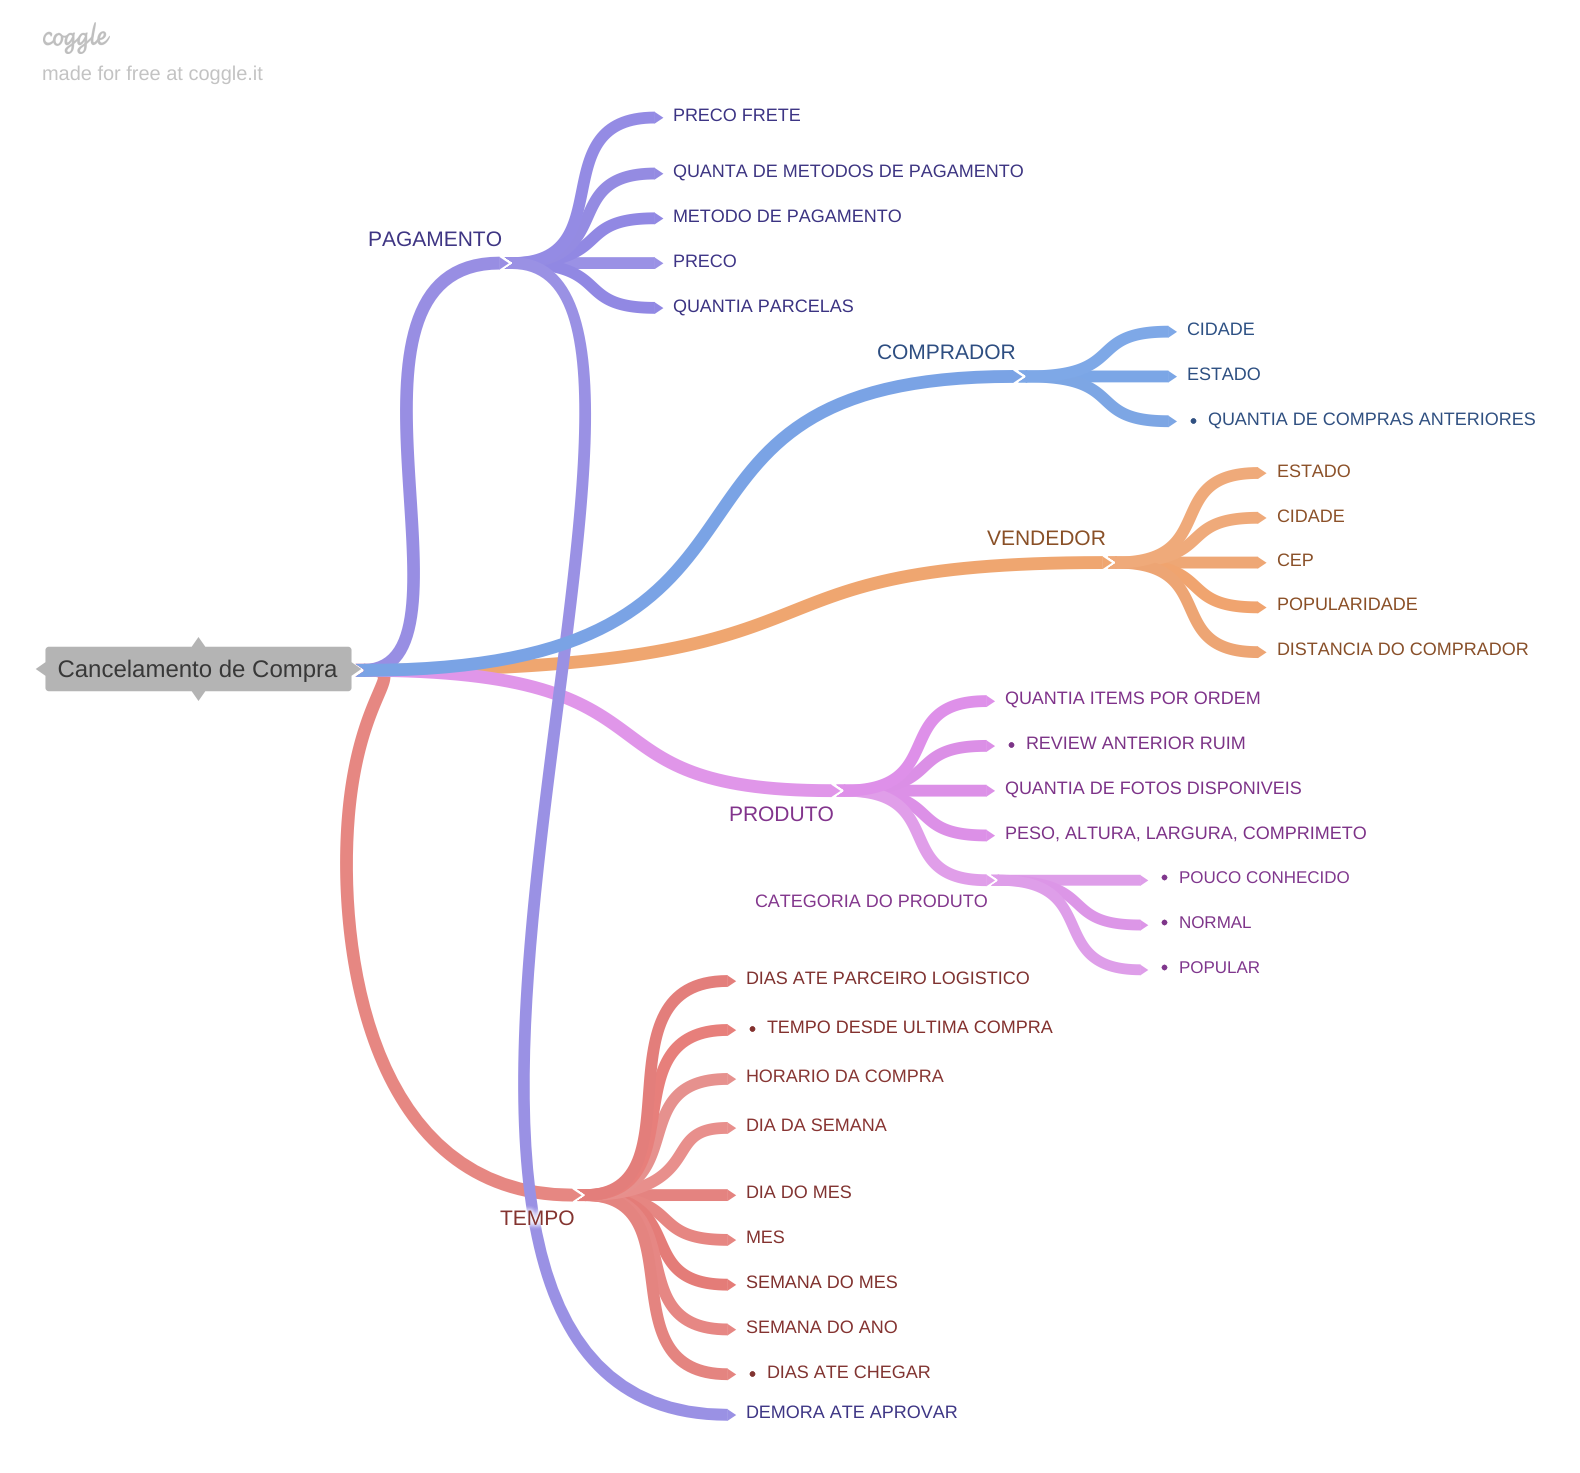

## 1.PAGAMENTO

### 1.1 Quanto mais caro o frete mais cancelam?

### 1.2 Quanto mais metodo de pagamento mais cancelam?

### 1.3 Depedendo do metodo de pagamento cancelam mais?

### 1.4 Quanto mais caro mais cancelam?

### 1.4 Quanto menos parcelado mais cancelam?

### 1.5 Quanto mais demora pra aprovar mais cancelam?

## 2.COMPRADOR

### 2.1Algumas cidades cancelam mais que outras?

### 2.2Alguns estados cancelam mais que outros?

### 2.3 Quanto menos produtos anteriormente comprados mais cancelamento?

## 3.Vendedor

### 3.1 Dependendo do Estado cancelam mais

### 3.2 Dependendo da cidade cancelam mais

### 3.3 Dependendo do CEP cancelam mais

### 3.4 Quanto menos conhecido o vendedor mais cancelam?

### 3.5 Quanto mais longe o vendedor mais cancelam?

## 4. PRODUTO

### 4.1 Quantos mais produtos por ordem mais cancelam

### 4.2 Quanto mais reviews ruins anteriores, mais cancelam Derivar

### 4.3 Quanto menos fotos no site mais cancelam

### 4.4 Quanto mais pessado o produto mais cancelam

### 4.5 Algumas categorias cancelam mais que outras

### 4.6 quanto menos conhecida a categoria do produto mais cancelam Derivar

## 5. TEMPO

### 5.1 Quanto mais tempo demora pra entregar pro parceiro logistico mais cancelam? Derivar

### 5.2 Quanto menos tempo desde a ultima compra mais cancelam? Derivar

### 5.3 Quanto mais perto da madrugada mais cancelam? Derivar

### 5.4 Alguns dias da semana cancelam mais que outros Derivar

### 5.5 Quanto mais próximo do final do mes cancelam mais? Derivar

### 5.7 Cancelam mais em alguns meses que em outros? Derivar

### 5.8 Cancelam mais na 4 semana do med que na 1 Derivar

### 5.9 Em algumas semanas do ano cancelam mais? Derivar

### 5.9/2 Quanto mais dias de data prevista de entrega mais cancelam? Derivar

# Derivando

### Tempo Aprovar pagamento

In [ ]:
df1 = df.copy()

In [ ]:
df1.columns

In [ ]:
df1['TEMPO_APROVACAO'] = df1['DATA_APROVACAO_PAGAMENTO'] - df1['DATA_PAGAMENTO']

In [ ]:
df1.sample()

### Quantia compras anteriores

In [ ]:
df1 = df1.sort_values(by='DATA_PAGAMENTO')

In [ ]:
df1['COMPRAS_TOTAIS_ID'] = df1.groupby('ID_CLIENTE')['ID_CLIENTE'].cumcount() + 1

In [ ]:
df1.sample()

### Popularidade vendedor

Farei esse "índice" com base em quantas vendas o vendedor fez até o momento

In [ ]:
df1['POPULARIDADE_VENDEDOR'] = df1.groupby('ID_VENDEDOR')['ID_VENDEDOR'].cumcount() + 1

In [ ]:
df1

### Quanto mais longe o vendedor mais cancelam?

In [ ]:
df1.columns

In [ ]:
df1[['PREFIXO_CEP_CLIENTE', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE']]

In [ ]:
localizador = Nominatim(user_agent='geolocalização')

In [ ]:
local = geolocator.geocode('Pinheiros, São Paulo')

In [2]:
dfdata.describe() # ver as colunas numéricas

# 1 coluna - Temos uma ordem ou mais com 21 items
# 2 coluna - Pessoas que pagram com 29 formas de pagamento diferentes?
# 3 coluna - Alguns parcelamentos foram em 24 vezes? Necessário olhar isso

# coluna 4, 5, & 6 - Entrando em preço temos um grande range, que vai de 0.85R$ até 6.735R$

# coluna 5 quantia de fotos do anuncio - Não acredito que essa coluna traga muito ganho de informação, vamos dar uma olhada

NameError: name 'dfdata' is not defined

# 1 coluna:

In [ ]:
sns.set(rc={'figure.figsize': (18, 6)})
sns.boxplot(data=dfdata, x='QUANTIA_ITEMS_NESSA_ORDEM');

# todos os valores acima de 1.0 por ordem ficaram como outliers devido a extrema concentração de pedidos com somente um item

In [ ]:
df_novo = dfdata.loc[df['QUANTIA_ITEMS_NESSA_ORDEM'] > 1]

In [ ]:
df_novo['VALOR_COMPRA'].describe()

In [ ]:
dfdata['VALOR_COMPRA'].describe()

Podemos ver que a distribuição dos preços nos pedidos que são outliers é bem diferente.

Apesar da grande quantia de outliers (14mil linhas) a informação de "quantia de items por ordem" pode ser importante prara o meu modelo, portanto eu irei deixar os outliers no projeto, mas é importante me lembrar disso para caso eu queira testar um aumento da asserividade no futuro.

# 2 Coluna:

In [ ]:
sns.boxplot(data=dfdata, x='QUANTIA_METODOS_PAGAMENTO');

Aqui também temos o mesmo caso que na quantia de items por compra, porém também acredito que essa variável possa indicar algum sinal de cancelamento, portanto, não vamos tirar mas é necessário manter essa variavel 

# 3 coluna:

In [ ]:
sns.boxplot(data=dfdata, x='QUANTIA_PARCELAS');

# temos pessoas que fizeram grandes quantias de parcelas

Análogo a as colunas anteriores irei deixar!

# 4, 5, e 6 coluna

In [ ]:
sns.displot(data=dfdata, x='PRECO_SEM_FRETE', height=13.25, aspect=16.7/7.0);

**Temos uma quantia absurdamente maior de pedidos no começo da distribuição dos dados, em uma distribuição assimetrica possitiva**

In [ ]:
sns.boxplot(data=dfdata, x='PRECO_SEM_FRETE');

In [ ]:
sns.displot(data=dfdata, x='PRECO_FRETE', height=13.25, aspect=16.7/10.25);

Já no preço do frete os valores estão melhores distribuidos

In [ ]:
sns.boxplot(data=dfdata, x='PRECO_FRETE');

Vamos ver se em algum desses fretes o estado do comprador e do vendedor são iguais, e onde o produto é leve para filtrar possiveis erros

In [ ]:
dfdata.loc[(dfdata['PRECO_FRETE'] > 88.6) & (dfdata['ESTADO_CLIENTE'] == dfdata['ESTADO_VENDEDOR']) & (dfdata['PESO_EM_GRAMAS'] < 2114)]

**Apararentemente filtrando os produtos com peso abaixo da média e no mesmo estado é raríssimo que alguém pague mais de 80.0 no Frete, e mesmo assim nos poucos casos as cidades são diferentes, portanto não acho os fretes caros se tratem de erros**

In [ ]:
sns.boxplot(data=dfdata, x='VALOR_COMPRA');

In [ ]:
sns.displot(data=dfdata, x='VALOR_COMPRA', height=13.25, aspect=18.7/7.0);

**Análogo a mesma situação, dos preços sem frete o preço padrão também está numa distribuição assimétrica positiva**

# Coluna 5:

In [ ]:
sns.boxplot(data=dfdata, x='QUANTIA_FOTOS_ANUNCIO');

**Alguns anúncios chegam a ter 20 fotos porém é provavel que nos algoritimos essa variável não traga muito ganho de informação**

In [ ]:
dfdata.columns

# Colunas de peso, altura, e largura

In [ ]:
sns.boxplot(data=dfdata, x='PESO_EM_GRAMAS');

Há uma quantia enorme de outliers nesse dado

In [ ]:
sns.histplot(data=dfdata, x='PESO_EM_GRAMAS');

Isso fica perceptível distribuição, os registros acima da média sáo bens mais notaveis  visivelmente, caso essa feature seja importante podemos suavizar ela mais pra frente

In [ ]:
sns.boxplot(data=dfdata, x='COMPRIMENTO_EM_CENTIMETROS');

No comprimento temos dados bem mais aceitaveis, a distribuição ainda é assimétrica possitiva porém não tanto

In [ ]:
sns.histplot(data=dfdata, x='COMPRIMENTO_EM_CENTIMETROS');

In [ ]:
sns.boxplot(data=dfdata, x='LARGURA_PRODUTO_EM_CENTIMETROS');

In [ ]:
sns.histplot(data=dfdata, x='LARGURA_PRODUTO_EM_CENTIMETROS');

O ponto de mais concentração é quase o mesmo do comprimento, 20cm

In [ ]:
sns.boxplot(data=dfdata, x='ALTURA_PRODUTO_EM_CENTIMETROS');

In [ ]:
sns.histplot(data=dfdata, x='ALTURA_PRODUTO_EM_CENTIMETROS');

Na altura temos o ponto de concentração menor

Como eu tenho várias medidas de tamanho, resolvi obersar outliers combinando as medias em uma expécie de gráfico de "voume" para ver se podem existir produtos com volumes excessivamente grandes

In [ ]:
df = px.data.iris()
grafico = px.scatter_3d(dfdata, x='ALTURA_PRODUTO_EM_CENTIMETROS', y='LARGURA_PRODUTO_EM_CENTIMETROS', z='COMPRIMENTO_EM_CENTIMETROS')

grafico.show()

A distribuição de tamanhos combinadas em um eixo 3d apontou produtos diferentes mas nada que pareca incorreto, algo visivel é o aparente limite de comprimento,  e altira, vários produtos parecem "travar" nessa faixa um pouco acima de 100, aparentemente existe um limite na plataforma

# Análise Exploratória

### Temos muitas colunas portanto há muito oque pesquisar nessa fase, tentarei obter alguns insights a respeito das variaveis, para tentar entender como elas se relacionam com a ordem ter sido cancelada ou não!

#### As colunas que podem ser observadas são:


    
'DATA_PAGAMENTO'
'DATA_ESTIMADA_ENTREGA'
'QUANTIA_ITEMS_NESSA_ORDEM'
'QUANTIA_METODOS_PAGAMENTO'
'METODO_PAGAMENTO'
'QUANTIA_PARCELAS'
'PRECO_SEM_FRETE'
'PRECO_FRETE'
'VALOR_COMPRA'
'NOME_CATEGORIA_PRODUTO'
'QUANTIA_FOTOS_ANUNCIO'
'PESO_EM_GRAMAS'
'COMPRIMENTO_EM_CENTIMETROS'
'LARGURA_PRODUTO_EM_CENTIMETROS'
'ALTURA_PRODUTO_EM_CENTIMETROS'
'PREFIXO_CEP_CLIENTE'
    'CIDADE_CLIENTE'
'ESTADO_CLIENTE'
    'PREFIXO_CEP_VENDEDOR'
'CIDADE_VENDEDOR'
'ESTADO_VENDEDOR'


##### Vou criar um dataframe apenas com os pedidos cancelados para observar quando precisar

In [ ]:
df = dfdata #facilitar digitação

In [ ]:
dfcancelados = df.loc[df['TARGET_STATUS_DA_ORDEM'] == 'canceled']

In [ ]:
df.columns

#### Primeiro vamos contar quantos métodos de pagamento existem, e observar a proporção de cancelados dentro deles

In [ ]:
sns.countplot(data=dfdata,
              x='TARGET_STATUS_DA_ORDEM', 
              hue='METODO_PAGAMENTO',
              palette='Greys_r');

A observação se dificulta pela proporção ce cancelados ser pequena mas abaixo coloquei o mesmo gráfico apenas com os cancelados

In [ ]:
sns.countplot(data=dfcancelados, 
              x='METODO_PAGAMENTO', 
              palette='Greys_r');

In [ ]:
# comparativo percentual

percentual_cartao_credito_geral = ((len(df.loc[df['METODO_PAGAMENTO'] == 'credit_card'])) / (len(df))) * 100
percentual_cartao_credito_cancelados = len(df.loc[(df['METODO_PAGAMENTO'] == 'credit_card') & (df['TARGET_STATUS_DA_ORDEM'] == "canceled")]) / (len(df.loc[df['TARGET_STATUS_DA_ORDEM'] == "canceled"])) * 100

In [ ]:
percentual_cartao_credito_geral

In [ ]:
percentual_cartao_credito_cancelados

**Portanto entre os pedidos cancelados o cartão de crédito foi utilizado em 4% a mais dos pedidos, o que aponta a possibilidade de fraude**

Colunas observadas com o target : 1/21

- 'DATA_PAGAMENTO'
- 'DATA_ESTIMADA_ENTREGA'
- 'QUANTIA_ITEMS_NESSA_ORDEM'
- 'QUANTIA_METODOS_PAGAMENTO'
- 'METODO_PAGAMENTO'-----------------OK
- 'QUANTIA_PARCELAS'
- 'PRECO_SEM_FRETE'
- 'PRECO_FRETE'
- 'VALOR_COMPRA'
- 'NOME_CATEGORIA_PRODUTO'
- 'QUANTIA_FOTOS_ANUNCIO'
- 'PESO_EM_GRAMAS'
- 'COMPRIMENTO_EM_CENTIMETROS'
- 'LARGURA_PRODUTO_EM_CENTIMETROS'
- 'ALTURA_PRODUTO_EM_CENTIMETROS'
- 'PREFIXO_CEP_CLIENTE'
- 'CIDADE_CLIENTE'
- 'ESTADO_CLIENTE'
- 'PREFIXO_CEP_VENDEDOR'
- 'CIDADE_VENDEDOR'
- 'ESTADO_VENDEDOR'


In [ ]:
sns.boxenplot(data=dfdata, 
              x='QUANTIA_METODOS_PAGAMENTO', 
              y='TARGET_STATUS_DA_ORDEM', 
              order=['delivered', 'canceled'],
              showfliers=False,
             linewidth=2.5);

In [ ]:
dfdata['QUANTIA_METODOS_PAGAMENTO'].loc[dfdata['TARGET_STATUS_DA_ORDEM'] != 'canceled'].mean()

In [ ]:
dfdata['QUANTIA_METODOS_PAGAMENTO'].loc[dfdata['TARGET_STATUS_DA_ORDEM'] == 'canceled'].mean()

**A média da quantia de pagamentos utilizados em uma classe e em outra é quase a mesma (1), é possível reparar isso pelo tamanho do traço em ambas as classificações portanto esse dado parece ser inconclusivo sozinho**

- 'DATA_PAGAMENTO'
- 'DATA_ESTIMADA_ENTREGA'
- 'QUANTIA_ITEMS_NESSA_ORDEM'
- 'QUANTIA_METODOS_PAGAMENTO' -------------- OK
- 'METODO_PAGAMENTO' -------------- OK
- 'QUANTIA_PARCELAS'
- 'PRECO_SEM_FRETE'
- 'PRECO_FRETE'
- 'VALOR_COMPRA'
- 'NOME_CATEGORIA_PRODUTO'
- 'QUANTIA_FOTOS_ANUNCIO'
- 'PESO_EM_GRAMAS'
- 'COMPRIMENTO_EM_CENTIMETROS'
- 'LARGURA_PRODUTO_EM_CENTIMETROS'
- 'ALTURA_PRODUTO_EM_CENTIMETROS'
- 'PREFIXO_CEP_CLIENTE'
- 'CIDADE_CLIENTE'
- 'ESTADO_CLIENTE'
- 'PREFIXO_CEP_VENDEDOR'
- 'CIDADE_VENDEDOR'
- 'ESTADO_VENDEDOR'

In [ ]:
dfdata['QUANTIA_ITEMS_NESSA_ORDEM'].loc[dfdata['TARGET_STATUS_DA_ORDEM'] != 'canceled'].mean()

In [ ]:
dfdata['QUANTIA_ITEMS_NESSA_ORDEM'].loc[dfdata['TARGET_STATUS_DA_ORDEM'] == 'canceled'].mean()

In [ ]:
sns.boxenplot(data=dfdata, 
              x='QUANTIA_ITEMS_NESSA_ORDEM', 
              y='TARGET_STATUS_DA_ORDEM', 
              order=['delivered', 'canceled', 'shipped'],
            linewidth=2.5
             );

**Pelo gráfico é possível reparar que as ordens canceladas tem um acúmulo maior de pedidos com mais items, é justamente isso que gera para essa categoria uma média de items por ordem maior**

**A quantia de items por ordem em pedidos cancelados é 7.59% maior que em pedidos normais!**

- 'DATA_PAGAMENTO'
- 'DATA_ESTIMADA_ENTREGA'
- 'QUANTIA_ITEMS_NESSA_ORDEM' -------------- OK
- 'QUANTIA_METODOS_PAGAMENTO' -------------- OK
- 'METODO_PAGAMENTO' -------------- OK
- 'QUANTIA_PARCELAS'
- 'PRECO_SEM_FRETE'
- 'PRECO_FRETE'
- 'VALOR_COMPRA'
- 'NOME_CATEGORIA_PRODUTO'
- 'QUANTIA_FOTOS_ANUNCIO'
- 'PESO_EM_GRAMAS'
- 'COMPRIMENTO_EM_CENTIMETROS'
- 'LARGURA_PRODUTO_EM_CENTIMETROS'
- 'ALTURA_PRODUTO_EM_CENTIMETROS'
- 'PREFIXO_CEP_CLIENTE'
- 'CIDADE_CLIENTE'
- 'ESTADO_CLIENTE'
- 'PREFIXO_CEP_VENDEDOR'
- 'CIDADE_VENDEDOR'
- 'ESTADO_VENDEDOR'

Agora vamos dar uma olhada na quantia de parcelas e como ela se relaciona com as difernentes classes

In [ ]:
sns.boxenplot(data=dfdata,
                x='QUANTIA_PARCELAS',
                y='TARGET_STATUS_DA_ORDEM',
                order=['delivered', 'canceled', 'shipped'],
                linewidth=2.5
                );

In [ ]:
dfdata['QUANTIA_PARCELAS'].loc[dfdata['TARGET_STATUS_DA_ORDEM'] != 'canceled'].mean()

In [ ]:
dfdata['QUANTIA_PARCELAS'].loc[dfdata['TARGET_STATUS_DA_ORDEM'] == 'canceled'].mean()

**Pedidos Cancelados parecem ser parcelados em 5.38% mais parcelas que a maioria dos pedidos**

- 'DATA_PAGAMENTO'
- 'DATA_ESTIMADA_ENTREGA'
- 'QUANTIA_ITEMS_NESSA_ORDEM' -------------- OK
- 'QUANTIA_METODOS_PAGAMENTO' -------------- OK
- 'METODO_PAGAMENTO' -------------- OK
- 'QUANTIA_PARCELAS'-------------- OK
- 'PRECO_SEM_FRETE'
- 'PRECO_FRETE'
- 'VALOR_COMPRA'
- 'NOME_CATEGORIA_PRODUTO'
- 'QUANTIA_FOTOS_ANUNCIO'
- 'PESO_EM_GRAMAS'
- 'COMPRIMENTO_EM_CENTIMETROS'
- 'LARGURA_PRODUTO_EM_CENTIMETROS'
- 'ALTURA_PRODUTO_EM_CENTIMETROS'
- 'PREFIXO_CEP_CLIENTE'
- 'CIDADE_CLIENTE'
- 'ESTADO_CLIENTE'
- 'PREFIXO_CEP_VENDEDOR'
- 'CIDADE_VENDEDOR'
- 'ESTADO_VENDEDOR'

Agora vamos entrar em preço! Vamos ver como o preço se relaciona com os diferentes status das ordens, e métodos de pagamento

In [ ]:
sns.boxenplot(data=dfdata,
                x='VALOR_COMPRA',
                y='TARGET_STATUS_DA_ORDEM',
                order=['delivered', 'canceled', 'shipped'],
                  showfliers=False,
                linewidth=2.0
                );

**Também vou plotar um histograma de preços em diferentes status das compras, assim consigo observar se os preços em ordens canceladas são maiores ou menores que nas outras, no entanto para isso, será necessário excluir outliers da visualização**